In [1]:
from utils.kinematic_arm import get_arm, get_distance_func
from copy import deepcopy
from time import time
from matplotlib import rcParams

from main_single_arm_cc import main as main_cc
from main_single_arm_transfer import main as main_transfer
from main_single_arm_bandit import main as main_bandit

import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt

import math
import numpy as np
import sys, os
import itertools

from evolution.operators import *
from utils.ea import continues_ea, transfer_continues_ea

# from pybrain.optimization.distributionbased.xnes import XNES
# from pybrain.optimization.distributionbased.snes import SNES
# from pybrain.optimization.distributionbased.cmaes import CMAES
# import map_elites.multitask as mt_map_elites
# import map_elites.common as cm_map_elites
from utils.data_manipulators import Tools
from utils.visualization_tools import *

In [2]:
SRC_SHAPES = ['-v', '-^', '-<', '-D']
TARGET_SHAPE = '-o'
SRC_COLORS = ['#00a8ff', '#9c88ff', '#fbc531' ,'#4cd137', '#487eb0', '#f368e0', '#ff9f43', '#ee5253', '#0abde3']
TARGET_COLOR = '#10ac84'

# Utils functions

In [3]:
# def cmaes():
#     cma = CMAES(storeAllEvaluations=True, storeAllEvaluated=True)
#     cma._allEvaluated
#     cma._allEvaluations
    
def fill_max(arr):
    out_arr = np.zeros_like(arr)
    max_val = float('-inf')
    for i, e in enumerate(arr):
        if e > max_val:
            max_val = e
        out_arr[i] = max_val
    return out_arr
    
def nes(fitness_func, init_chrom, psize=50, iter_num=100, nes_type='xnes', verbose=False):
    opt = {'xnes': XNES, 'snes': SNES}
    alg = opt[nes_type]
    x = alg(fitness_func, init_chrom, verbose=verbose)
    x.batchSize = psize
    x.maxEvaluations = iter_num*psize
    x.learn()
    
    pops = np.zeros((iter_num, psize, len(init_chrom)))
    fitness_vals = np.zeros((iter_num, psize))
    for i in range(iter_num):
        pops[i, :, :] = np.array(x._allEvaluated[i*psize:(i+1)*psize])
        fitness_vals[i, :] = np.array(x._allEvaluations[i*psize:(i+1)*psize])
    return pops, fitness_vals

SRC_SHAPES = ['-v', '-^', '-<', '-D']
TARGET_SHAPE = '-o'
SRC_COLORS = ['#f368e0', '#ff9f43', '#ee5253', '#0abde3']
TARGET_COLOR = '#10ac84'


def get_fitness(results):
    fitnesses = np.zeros_like(results)
    for i, rep in enumerate(results):
        for j, gen in enumerate(rep):
            if gen.any() is not None:
                fitnesses[i, j, :] = Chromosome.fitness_to_numpy(gen)
    return fitnesses

def time_concat(time_hist):
    for i in range(1, len(time_hist)):
        time_hist[i] += np.abs(time_hist[i-1])
    return time_hist

def get_convergence_index(mean_fitnesses, converge_limit=5):
    not_changed_count = 0
    if np.min(mean_fitnesses) < 0:
        mean_fitnesses = -(np.min(mean_fitnesses))+ mean_fitnesses
    for idx, fitness in enumerate(mean_fitnesses):
        if (fitness - mean_fitnesses[idx-1])/mean_fitnesses[idx-1]< 0.0001:
            not_changed_count += 1
        else:
            not_changed_count = 0
            
        if not_changed_count == converge_limit:
            break
    
    return idx

def align_convergence(mean_fitnesses, mean_times, convergence_time, std_fitnesses=None):
    if mean_times[-1] <= convergence_time:
        return mean_fitnesses, mean_times, std_fitnesses
    
    for idx, t in enumerate(mean_times):
        if t > convergence_time:
            break
    if std_fitnesses is not None:
        return mean_fitnesses[:idx+1], mean_times[:idx+1], std_fitnesses[:idx+1]
    return mean_fitnesses[:idx+1], mean_times[:idx+1]

def to_right_gen(inp):
    new_inp = np.zeros((inp.shape[0], 100, inp.shape[2]))
    for i in range(100):
        
        if i%2 ==0 and int(i/2)<inp.shape[1]:
            new_inp[:, i, :] = inp[:, int(i/2), :]
        else:
            new_inp[:, i, :] = new_inp[:, i-1, :]
    return new_inp

# Algorithm

In [17]:
max_angle = 1
related_num = 15
joint_num = 20
target_joint_num = joint_num

In [18]:
# Loading Source Models

In [19]:
related_dir = 'models/arm/clusters/related_{}/'.format(joint_num)
related_files = os.listdir(related_dir)
unrelated_num = 1000 - related_num
unrelated_dir = 'models/arm/clusters/unrelated_{}/'.format(joint_num)
unrelated_files = os.listdir(unrelated_dir)
print(len(unrelated_files))

target_joint_num = joint_num
target_arm_length = np.sqrt(2)
target_max_angle = max_angle
target_pos = np.array([1, 1])

target_fitness_func = get_distance_func(get_arm(target_arm_length, target_joint_num), target_max_angle, target_pos, obj_type='negative_obj')

src_models = []
for i in range(related_num):
    src_models.append(Tools.load_from_file((related_dir + related_files[i])[:-4]))
    print('Related Sources Expectation')
    expec = 0
    for j in range(100):
        sample = src_models[-1].sample(1)[0]
        expec += target_fitness_func(sample)
    print(expec/100)
    
for i in range(unrelated_num):
    src_models.append(Tools.load_from_file((unrelated_dir + unrelated_files[i])[:-4]))
    print('Unrelated Sources Expectation')
    expec = 0
#     for j in range(100):
#         sample = src_models[-1].sample(1)[0]
#         expec += target_fitness_func(sample)
    print(expec/100)

1001
Related Sources Expectation
-0.002114598829744076
Related Sources Expectation
-0.0011511659365745618
Related Sources Expectation
-0.0009119287316617173
Related Sources Expectation
-0.0019888780232510924
Related Sources Expectation
-0.002058092031544046
Related Sources Expectation
-0.0010771771294312857
Related Sources Expectation
-0.014661828656385122
Related Sources Expectation
-0.00170479517146819
Related Sources Expectation
-0.009423198481733305
Related Sources Expectation
-0.00174443938383263
Related Sources Expectation
-0.0012751369523961514
Related Sources Expectation
-0.0018017910196441356
Related Sources Expectation
-0.0007753126006378099
Related Sources Expectation
-0.0013941083120342084
Related Sources Expectation
-0.0018710753511896148
Unrelated Sources Expectation
0.0
Unrelated Sources Expectation
0.0
Unrelated Sources Expectation
0.0
Unrelated Sources Expectation
0.0
Unrelated Sources Expectation
0.0
Unrelated Sources Expectation
0.0
Unrelated Sources Expectation
0.0


KeyboardInterrupt: 

In [21]:
class args:
    sample_size=50
    reps = 30
    delta = 2
    joint_num = target_joint_num
    target_length = np.sqrt(2)
    target_pos = np.array([1, 1])
    max_angle = max_angle
    src_models = src_models
    buildmodel = False
    psize = 50
    gen = 100
    
start = time()
fitness_hist_transfer, alpha_transfer, fitness_time_transfer = main_transfer(args)
end = time()
print("duration: ", str((end - start)/60))
Tools.save_to_file('results/main_sequential_transfer_arm_{}_related_{}_jointnum_{}_50p'.format(max_angle, related_num, target_joint_num), [fitness_hist_transfer, alpha_transfer, fitness_time_transfer])

------------------------ rep: 0 ---------------------
Generation 0 best fitness = -1.038368
Generation 1 best fitness = -0.812380
0
Mixture coefficients: [0.00126054 0.0005593  0.00072603 ... 0.00152618 0.00144737 0.16688553]
cfitness mean:  -2.742608043317512
Generation 2 best fitness = -0.812380
Generation 3 best fitness = -0.812380
0
Mixture coefficients: [0.00020751 0.0008613  0.00141278 ... 0.00047224 0.00145137 0.17209645]
cfitness mean:  -2.742991418019111
Generation 4 best fitness = -0.812380
Generation 5 best fitness = -0.812380
0
Mixture coefficients: [0.00158181 0.00048645 0.0009806  ... 0.00159273 0.00030711 0.1678837 ]
cfitness mean:  -2.735883790148738
Generation 6 best fitness = -0.812380
Generation 7 best fitness = -0.812380
0
Mixture coefficients: [0.000533   0.00052079 0.00152404 ... 0.00112532 0.00109131 0.16839941]
cfitness mean:  -2.677992836451578
Generation 8 best fitness = -0.000808
Generation 9 best fitness = -0.000808
0
Mixture coefficients: [1.15371254e-03 3.

0
Mixture coefficients: [0.00118702 0.0021551  0.00241343 ... 0.00115277 0.00182602 0.03160796]
cfitness mean:  -2.6844164676352182
Generation 80 best fitness = -0.000493
Generation 81 best fitness = -0.000493
0
Mixture coefficients: [0.00276144 0.0015291  0.00325299 ... 0.00025507 0.0010427  0.03052895]
cfitness mean:  -2.7402851671814505
Generation 82 best fitness = -0.000493
Generation 83 best fitness = -0.000493
0
Mixture coefficients: [0.00169319 0.00201589 0.00256804 ... 0.00120598 0.00082881 0.0334763 ]
cfitness mean:  -2.685752895332631
Generation 84 best fitness = -0.000493
Generation 85 best fitness = -0.000493
0
Mixture coefficients: [0.00225009 0.00236664 0.00273238 ... 0.00146025 0.00079651 0.03074714]
cfitness mean:  -2.759238136458022
Generation 86 best fitness = -0.000493
Generation 87 best fitness = -0.000493
0
Mixture coefficients: [0.00246683 0.0011008  0.00216465 ... 0.00032165 0.0012884  0.0356706 ]
cfitness mean:  -2.740529945264628
Generation 88 best fitness = -0

0
Mixture coefficients: [0.00219325 0.00114625 0.00340631 ... 0.00038719 0.00062164 0.03971157]
cfitness mean:  -2.739402274349561
Generation 60 best fitness = -0.000481
Generation 61 best fitness = -0.000481
0
Mixture coefficients: [0.00175352 0.00174655 0.00307549 ... 0.00135035 0.00087924 0.02749277]
cfitness mean:  -2.6772987393752796
Generation 62 best fitness = -0.000413
Generation 63 best fitness = -0.000413
0
Mixture coefficients: [0.0012653  0.0014579  0.00294778 ... 0.00126788 0.00134705 0.03199024]
cfitness mean:  -2.6204773883546544
Generation 64 best fitness = -0.000413
Generation 65 best fitness = -0.000413
0
Mixture coefficients: [0.00182663 0.00260181 0.00359686 ... 0.00016981 0.0008536  0.03848179]
cfitness mean:  -2.744944378980748
Generation 66 best fitness = -0.000413
Generation 67 best fitness = -0.000413
0
Mixture coefficients: [0.00132288 0.00185277 0.00358362 ... 0.00042013 0.00038577 0.03202548]
cfitness mean:  -2.7790644863042013
Generation 68 best fitness = -

0
Mixture coefficients: [0.00115052 0.00233237 0.00244969 ... 0.00070355 0.00084146 0.04024243]
cfitness mean:  -2.569189197018649
Generation 40 best fitness = -0.000540
Generation 41 best fitness = -0.000474
0
Mixture coefficients: [0.00113701 0.00146724 0.00339468 ... 0.00036849 0.00086982 0.03532787]
cfitness mean:  -2.585763097499609
Generation 42 best fitness = -0.000474
Generation 43 best fitness = -0.000474
0
Mixture coefficients: [0.00181244 0.00110466 0.0031998  ... 0.00058658 0.00102974 0.02999957]
cfitness mean:  -2.73247752458896
Generation 44 best fitness = -0.000474
Generation 45 best fitness = -0.000474
0
Mixture coefficients: [0.00222065 0.00184915 0.0031706  ... 0.00088099 0.00143099 0.03346526]
cfitness mean:  -2.7559412478677574
Generation 46 best fitness = -0.000474
Generation 47 best fitness = -0.000474


KeyboardInterrupt: 

In [ ]:
class args:
    sample_size=50
    reps = 30
    delta = 2
    joint_num = target_joint_num
    target_length = np.sqrt(2)
    target_pos = np.array([1, 1])
    src_models = src_models
    max_angle = max_angle
    buildmodel=False
    psize = 50
    gen = 200

start = time()
fitness_hist_bandit, alpha_bandit, prob_bandit, fitness_time_bandit = main_bandit(args)
end = time()
print("duration: ", str((end - start)/60))
Tools.save_to_file('results/main_sequential_bandit_arm_{}_related_{}_jointnum_{}_50p'.format(max_angle, related_num, target_joint_num), [fitness_hist_bandit, alpha_bandit, prob_bandit, fitness_time_bandit])

In [ ]:
class args:
    sample_size=50
    reps = 30
    delta = 2
    initial_lr = 0.9
    joint_num = target_joint_num
    target_length = np.sqrt(2)
    target_pos = np.array([1, 1])
    max_angle = max_angle
    src_models = src_models
    psize = 50
    gen = 100
    initial_genes_value = 1/1001
    buildmodel = False
    
start = time()
fitness_hist_cc, genes_list_cc, fitness_time_cc = main_cc(args)
end = time()
print("duration: ", str((end - start)/60))
Tools.save_to_file('results/main_sequential_cc_arm_{}_related_{}_jointnum_{}_50p'.format(max_angle, related_num, target_joint_num), [fitness_hist_cc, genes_list_cc, fitness_time_cc])

In [ ]:
# target_joint_num = joint_num
# target_arm_length = np.sqrt(2)
# target_max_angle = max_angle
# target_pos = np.array([1, 1])

# target_fitness_func = get_distance_func(get_arm(target_arm_length, target_joint_num), target_max_angle, target_pos, obj_type='negative_obj')

# xnes_fitness = np.zeros((30, 100, 50))
# xnes_time = np.zeros((30, 100))
# snes_fitness = np.zeros((30, 100, 50))
# snes_time = np.zeros((30, 100))

# for i in range(30):
#     s = time()
#     _, xnes_fitness[i, ...] = nes(target_fitness_func, np.random.rand(target_joint_num))
#     xnes_time[i, :] = (time() - s)/100
#     s = time()
#     _, snes_fitness[i, ...] = nes(target_fitness_func, np.random.rand(target_joint_num), nes_type='snes')
#     snes_time[i, :] = (time() - s)/100

# Tools.save_to_file('results/xnes_results_arm_{}_jointnum_{}_50p'.format(max_angle, target_joint_num), [xnes_fitness, xnes_time])
# Tools.save_to_file('results/snes_results_arm_{}_jointnum_{}_50p'.format(max_angle, target_joint_num), [snes_fitness, snes_time])

In [22]:
fitness_hist_transfer, alpha_transfer, fitness_time_transfer = Tools.load_from_file('results/main_sequential_transfer_arm_{}_related_{}_jointnum_{}_50p'.format(max_angle, related_num, target_joint_num))
fitness_hist_cc, genes_list_cc, fitness_time_cc = Tools.load_from_file('results/main_sequential_cc_arm_{}_related_{}_jointnum_{}_50p'.format(max_angle, related_num, target_joint_num))
fitness_hist_bandit, alpha_bandit, prob_bandit, fitness_time_bandit = Tools.load_from_file('results/main_sequential_bandit_arm_{}_related_{}_jointnum_{}_50p'.format(max_angle, related_num, target_joint_num))
xnes_results = Tools.load_from_file('results/xnes_results_arm_{}_jointnum_{}_50p'.format(max_angle, target_joint_num))
snes_results = Tools.load_from_file('results/snes_results_arm_{}_jointnum_{}_50p'.format(max_angle, target_joint_num))

In [23]:
fitness_hist_transfer = fitness_hist_transfer[:,:100,:].mean(2)
fitness_time_transfer = np.cumsum(fitness_time_transfer.mean(0))[:100]

fitness_hist_cc = fitness_hist_cc[:,:100,:].mean(2)
fitness_time_cc = np.cumsum(fitness_time_cc.mean(0))[:100]

fitness_hist_bandit = fitness_hist_bandit[:,:200,:].mean(2)
fitness_time_bandit = np.cumsum(fitness_time_bandit.mean(0))[:200]

xnes_fitness = xnes_results[0].mean(2)
xnes_time = np.cumsum(xnes_results[1].mean(0))
snes_fitness = snes_results[0].mean(2)
snes_time = np.cumsum(snes_results[1].mean(0))

In [24]:
# plot_time_bars([multi_cc_knapsack_kp1000_time[-1], multi_transfer_knapsack_kp1000_time[-1], multi_bandit_knapsack_kp1000_time[-1],
#                xnes_time[-1], snes_time[-1]], ['AMCTEA', 'AMTEA', 'MAB-AMTEA', 'XNES', 'SNES'], multi_cc_knapsack_kp1000_time[-1],
#               'plots/arm/arm-bar-time-{}_related-num-{}_jointnum-{}_average.pdf'.format(max_angle, related_num, joint_num))

In [25]:
#post processing time
conv_idx = get_convergence_index(fitness_hist_cc.mean(0), 5)

conv_fitness_hist_cc, conv_fitness_time_cc, conv_std_fitness_hist_cc = \
    fitness_hist_cc.mean(0)[:conv_idx+1], fitness_time_cc[:conv_idx+1], fitness_hist_cc.std(0)[:conv_idx+1]

conv_fitness_hist_transfer, conv_fitness_time_transfer, conv_std_fitness_hist_transfer = \
    align_convergence(fitness_hist_transfer.mean(0), fitness_time_transfer,
                      fitness_time_cc[conv_idx], fitness_hist_transfer.std(0))

conv_fitness_hist_bandit, conv_fitness_time_bandit, conv_std_fitness_hist_bandit = \
    align_convergence(fitness_hist_bandit.mean(0), fitness_time_bandit,
                      fitness_time_cc[conv_idx], fitness_hist_bandit.std(0))

/home/oriea/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:54: RuntimeWarning: divide by zero encountered in double_scalars


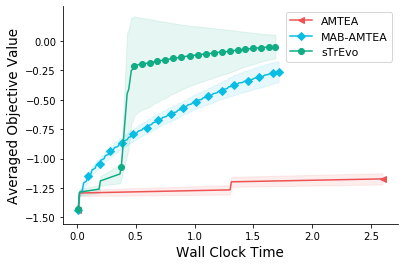

In [26]:
plt.figure()
plot_mean_std(conv_fitness_hist_transfer[None], SRC_COLORS[-2], 'AMTEA', SRC_SHAPES[-2], conv_fitness_time_transfer[:], std=True, data_std=conv_std_fitness_hist_transfer)
plot_mean_std(conv_fitness_hist_bandit[None], SRC_COLORS[-1], 'MAB-AMTEA', SRC_SHAPES[-1], conv_fitness_time_bandit[:], std=True, data_std=conv_std_fitness_hist_bandit)
plot_mean_std(conv_fitness_hist_cc[None], TARGET_COLOR, 'sTrEvo', TARGET_SHAPE, conv_fitness_time_cc[:], std=True, data_std=conv_std_fitness_hist_cc)
# plt.vlines(con_converge_times.mean(), multi_transfer_knapsack_kp4_fitness_acc.min()-50, multi_transfer_knapsack_kp4_fitness_acc.max(), linestyles='dashed')
design_plot()
# plt.legend(loc='lower right')
# plt.ylim(multi_transfer_knapsack_kp4_fitness_acc.min()-50, multi_transfer_knapsack_kp4_fitness_acc.max() + 50)
# plt.xticks(list(range(0,81, 20)) + [con_converge_times.mean()] + list(range(120,161, 20)))
# plt.savefig('plots/average_AMTEA.jpg')
plt.yticks([-1.5 , -1.25, -1.  , -0.75, -0.5 , -0.25,  0.])
save_plot('plots/arm/arm-time-{}_related-num-{}_jointnum-{}_average.pdf'.format(max_angle, related_num, joint_num))

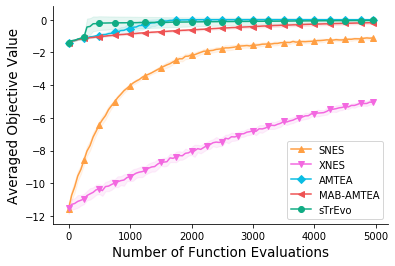

In [27]:
plt.figure()

plot_mean_std(snes_fitness[:, :], SRC_COLORS[-3], 'SNES', SRC_SHAPES[-3], std=True, x_interval=50)
plot_mean_std(xnes_fitness[:, :], SRC_COLORS[-4], 'XNES', SRC_SHAPES[-4], std=True, x_interval=50)
plot_mean_std(fitness_hist_transfer[:, :], SRC_COLORS[-1], 'AMTEA', SRC_SHAPES[-1], std=True, x_interval=50)
plot_mean_std(fitness_hist_bandit[:, :100], SRC_COLORS[-2], 'MAB-AMTEA', SRC_SHAPES[-2], std=True, x_interval=50)
plot_mean_std(fitness_hist_cc[:, :], TARGET_COLOR, 'sTrEvo', TARGET_SHAPE, std=True, x_interval=50)

# plt.vlines(con_converge_times.mean(), multi_transfer_knapsack_kp4_fitness_acc.min()-50, multi_transfer_knapsack_kp4_fitness_acc.max(), linestyles='dashed')
design_plot('f')
plt.legend(loc='lower right')
# plt.ylim(multi_transfer_knapsack_kp4_fitness_acc.min()-50, multi_transfer_knapsack_kp4_fitness_acc.max() + 50)
# plt.xticks(list(range(0,81, 20)) + [con_converge_times.mean()] + list(range(120,161, 20)))
# plt.ylim(-8.5, .5)
# plt.yticks([-8, -6, -4, -2, 0])
save_plot('plots/arm/arm-generation-{}_related-num-{}_jointnum-{}_average.pdf'.format(max_angle, related_num, joint_num))

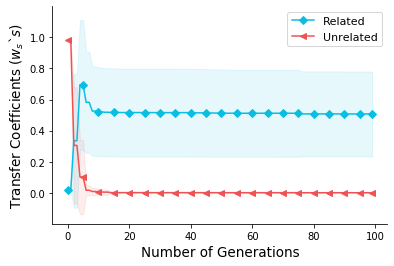

In [28]:
c = to_right_gen(np.array(genes_list_cc))
plt.figure()

plot_mean_std(c[:, :,:related_num].sum(2)/c.sum(axis=2), SRC_COLORS[-1], 'Related', SRC_SHAPES[-1])
plot_mean_std(c[:, :,related_num:999].sum(2)/c.sum(axis=2), SRC_COLORS[-2], 'Unrelated', SRC_SHAPES[-2])
# plt.yticks([0, .2, .4, .6, .8, 1.])

design_plot(x_label='g', y_label='c')
plt.ylim(-0.2, 1.2)
plt.yticks([0, .2, .4, .6, .8, 1.])
save_plot('plots/arm/arm-learning-sTrEvo-{}_related-num-{}_jointnum-{}_average.pdf'.format(max_angle, related_num, joint_num))

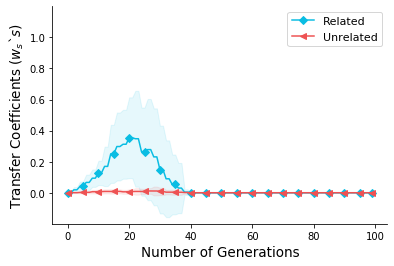

In [29]:
c = to_right_gen(np.array(alpha_transfer[:100]).reshape(30, 49, 1001))
plt.figure()

plot_mean_std(c[:, :,0:related_num].sum(2)/c.sum(axis=2), SRC_COLORS[-1], 'Related', SRC_SHAPES[-1])
plot_mean_std(c[:, :,related_num:1000].sum(2)/c.sum(axis=2), SRC_COLORS[-2], 'Unrelated', SRC_SHAPES[-2])
# plt.yticks([0, .2, .4, .6, .8, 1.])

design_plot(x_label='g', y_label='c')
plt.ylim(-0.2, 1.2)
plt.yticks([0, .2, .4, .6, .8, 1.])
save_plot('plots/arm/arm-learning-AMTEA-{}_related-num-{}_jointnum-{}_average.pdf'.format(max_angle, related_num, joint_num))